<a href="https://colab.research.google.com/github/savitagaina/ML-Based-Credit-Risk-Assessment-Model/blob/main/Copy_of_Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                               ML-Based Credit Risk Assessment Model



## Problem Statement

The objective of this project is to analyze customer loan data and build
a predictive model to identify customers who are likely to default on
home loans. The goal is to help financial institutions reduce credit
risk by accurately identifying high-risk applicants using machine
learning techniques.


## Dataset Description

The dataset consists of multiple tables related to customer loan
applications and credit history:

- application_train.csv: Main dataset containing customer information
  and target variable (default or not).
- bureau.csv & bureau_balance.csv: Customer credit history from external
  financial institutions.
- POS_CASH_balance.csv: Point-of-sale and cash loan payment history.
- credit_card_balance.csv: Credit card usage and repayment behavior.
- installments_payments.csv: Installment repayment records.
- previous_application.csv: Previous loan application history.

Each dataset provides different behavioral and financial insights
required for accurate credit risk modeling.


# (1) Importing required libraries

In [ ]:
# Numerical and data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")


#(2)UPLOADING DATASETS

In [ ]:
import pandas as pd

application = pd.read_csv("/content/application_train.csv")
bureau = pd.read_csv("/content/bureau.csv")
bureau_balance = pd.read_csv("/content/bureau_balance.csv")
credit_card = pd.read_csv("/content/credit_card_balance.csv")
installments = pd.read_csv("/content/installments_payments.csv")
previous_app = pd.read_csv("/content/installments_payments.csv")
pos_cash = pd.read_csv("/content/POS_CASH_balance.csv")


FileNotFoundError: [Errno 2] No such file or directory: '/content/application_train.csv'

In [ ]:
application.info()

NameError: name 'application' is not defined

## (3) Exploratory Data Analysis(EDA)

In [ ]:
application.shape


(46592, 122)

In [ ]:
application['TARGET'].value_counts()


,count
TARGET,
0,42840
1,3752


In [ ]:
application['TARGET'].value_counts(normalize=True) * 100


,proportion
TARGET,
0,91.947115
1,8.052885


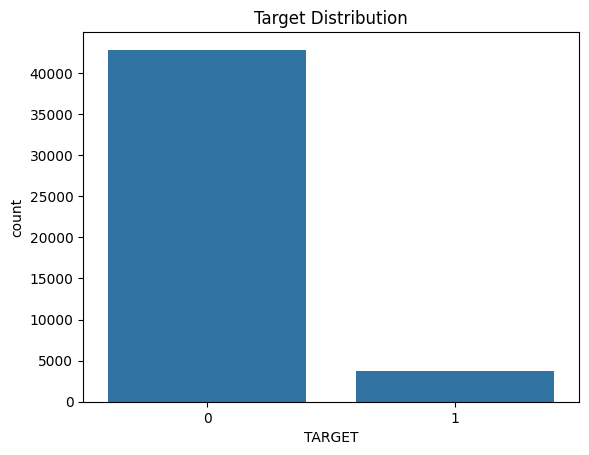

In [ ]:
sns.countplot(x='TARGET', data=application)
plt.title("Target Distribution")
plt.show()


The target variable is highly imbalanced, with defaulters accounting for
approximately 8% of the total observations. This highlights the need
for special techniques to handle class imbalance during model training.


### Target vs Total Income

This analysis compares applicant income distribution between defaulters
and non-defaulters to understand whether income level influences loan
default behavior.


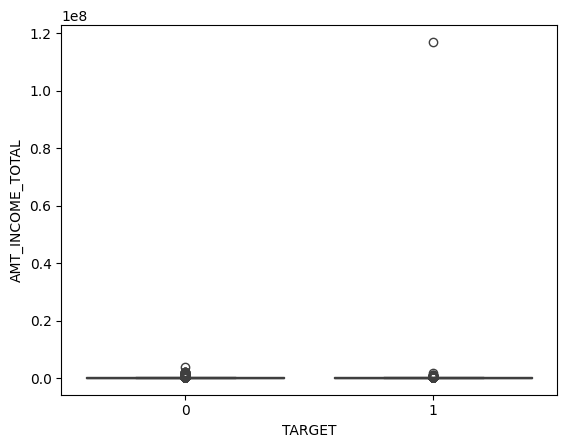

In [ ]:
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=application)
plt.show()


### Target vs Credit Amount

This visualization examines whether higher credit amounts are associated
with increased default risk.


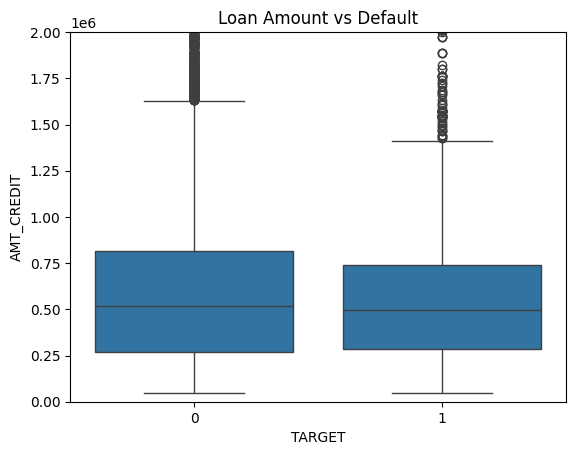

In [ ]:
# Credit Amount vs Loan Default
sns.boxplot(x='TARGET', y='AMT_CREDIT', data=application)
plt.ylim(0, 2000000)
plt.title("Loan Amount vs Default")
plt.show()


The boxplot indicates that the median loan amount is similar for both
defaulters and non-defaulters, with significant overlap in their
distributions. This suggests that loan amount alone is not a strong
predictor of default and must be evaluated in combination with other
customer and behavioral features.


### Target vs Age

Customer age was derived from DAYS_BIRTH to analyze default patterns
across different age groups.


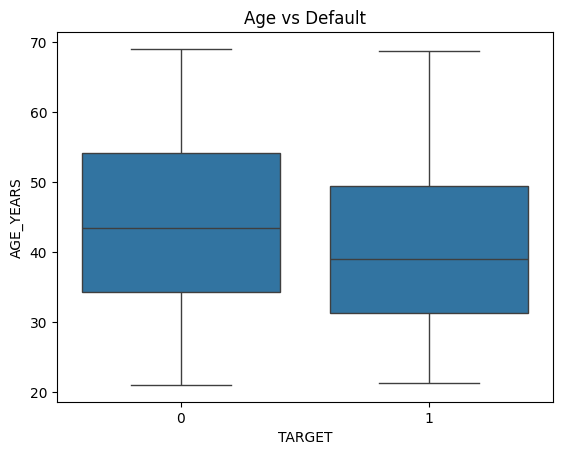

In [ ]:
# AGE vs LOAN DEFAULT
# Convert days to years
application['AGE_YEARS'] = -application['DAYS_BIRTH'] / 365

sns.boxplot(x='TARGET', y='AGE_YEARS', data=application)
plt.title("Age vs Default")
plt.show()


The boxplot shows that defaulters are generally younger than
non-defaulters. The lower median age for defaulters suggests that
younger applicants may have higher default risk, possibly due to
lower financial stability. However, the overlap in age ranges
indicates that age alone is not sufficient to predict default.


Non-defaulters (0)
Median age ≈ 43–44 years

Defaulters (1)
Median age ≈ 38–39 years

This indicates:

Defaulters tend to be younger than non-defaulters.

# Education Level vs Default

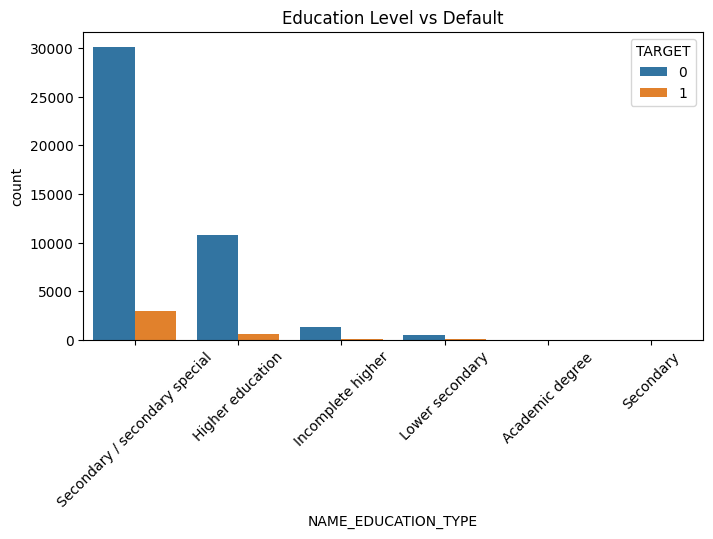

In [ ]:
# EDUCATION LEVEL vs DEFAULT
plt.figure(figsize=(8,4))
sns.countplot(x='NAME_EDUCATION_TYPE', hue='TARGET', data=application)
plt.xticks(rotation=45)
plt.title("Education Level vs Default")
plt.show()


The count plot indicates that applicants with higher education levels
exhibit lower default rates compared to those with lower education
levels. Customers with academic degrees show the least default
occurrence, suggesting that education level is an important indicator
of financial stability.


In [ ]:
bureau.head()


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131.0,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20.0,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16.0,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16.0,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21.0,NaN


## Feature Engineering


In [ ]:
grouped_bureau = bureau.groupby("SK_ID_CURR")


In [ ]:
grouped_bureau.get_group(bureau['SK_ID_CURR'].iloc[0])


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.00,NaN,0.0,Consumer credit,-131.0,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.00,NaN,0.0,Credit card,-20.0,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16.0,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16.0,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21.0,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.0,71017.38,108982.62,0.0,Credit card,-31.0,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.8,42103.80,0.00,0.0,Consumer credit,-22.0,NaN
225157,215354,5714458,Closed,currency 1,-1872,0,-776.0,-1203.0,NaN,0,494550.0,0.00,0.00,0.0,Consumer credit,-696.0,NaN
225158,215354,5714459,Closed,currency 1,-1734,0,-638.0,-1336.0,NaN,0,1084032.0,0.00,NaN,0.0,Car loan,-1336.0,NaN
225159,215354,5714460,Closed,currency 1,-1333,0,-1089.0,-987.0,NaN,0,102150.0,NaN,NaN,0.0,Consumer credit,-984.0,NaN


Based on insights from EDA, feature engineering was performed to capture
customers’ historical credit behavior. Since the data was spread across
multiple transactional tables, aggregation techniques were used to
convert transaction-level data into customer-level features.


Grouping by SK_ID_CURR allows us to combine all bureau records belonging
to a single customer, which is required to create customer-level features.


In [ ]:

# BUREAU FEATURE ENGINEERING


# 1. Count of previous bureau loans
bureau_count = (
    bureau.groupby("SK_ID_CURR")["SK_ID_BUREAU"]
    .count()
    .reset_index()
    .rename(columns={"SK_ID_BUREAU": "BUREAU_LOAN_COUNT"})
)

# 2. Credit amount behavior (mean & max)
bureau_amt = (
    bureau.groupby("SK_ID_CURR")["AMT_CREDIT_SUM"]
    .agg(["mean", "max"])
    .reset_index()
)
bureau_amt.columns = ["SK_ID_CURR", "BUREAU_CREDIT_MEAN", "BUREAU_CREDIT_MAX"]

# 3. Worst overdue behavior
bureau_overdue = (
    bureau.groupby("SK_ID_CURR")["CREDIT_DAY_OVERDUE"]
    .max()
    .reset_index()
    .rename(columns={"CREDIT_DAY_OVERDUE": "BUREAU_MAX_OVERDUE"})
)

# 4. Merge all bureau features together
bureau_features = bureau_count.merge(bureau_amt, on="SK_ID_CURR", how="left")
bureau_features = bureau_features.merge(bureau_overdue, on="SK_ID_CURR", how="left")

# 5. Merge bureau features with application data
application = application.merge(bureau_features, on="SK_ID_CURR", how="left")

# 6. Check result
application.shape


(46592, 127)

In [ ]:

# POS_CASH FEATURE ENGINEERING


# 1. Aggregate POS_CASH data at customer level
pos_features = (
    pos_cash.groupby("SK_ID_CURR")
    .agg({
        "SK_ID_PREV": "count",      # number of POS / cash loans
        "MONTHS_BALANCE": "mean",   # average loan duration
        "SK_DPD": "max",            # max days past due
        "SK_DPD_DEF": "max"         # max severe delinquency
    })
    .reset_index()
)

# 2. Rename columns for clarity
pos_features.rename(columns={
    "SK_ID_PREV": "POS_LOAN_COUNT",
    "MONTHS_BALANCE": "POS_MONTHS_AVG",
    "SK_DPD": "POS_MAX_DPD",
    "SK_DPD_DEF": "POS_MAX_DPD_DEF"
}, inplace=True)

# 3. Merge POS features with application data
application = application.merge(pos_features, on="SK_ID_CURR", how="left")

# 4. Check result
application.shape


(46592, 131)

In [ ]:

# INSTALLMENTS PAYMENTS FEATURE ENGINEERING


# 1. Create payment difference feature
installments["PAYMENT_DIFF"] = (
    installments["AMT_PAYMENT"] - installments["AMT_INSTALMENT"]
)

# 2. Aggregate repayment behavior at customer level
inst_features = (
    installments.groupby("SK_ID_CURR")
    .agg({
        "PAYMENT_DIFF": ["mean", "min"],     # payment discipline
        "DAYS_ENTRY_PAYMENT": "mean"         # payment timing
    })
    .reset_index()
)

# 3. Flatten column names
inst_features.columns = [
    "SK_ID_CURR",
    "INST_PAYMENT_DIFF_MEAN",
    "INST_PAYMENT_DIFF_MIN",
    "INST_DAYS_ENTRY_MEAN"
]

# 4. Merge installments features with application data
application = application.merge(inst_features, on="SK_ID_CURR", how="left")

# 5. Check result
application.shape


(46592, 134)

In [ ]:

# CREDIT CARD BALANCE FEATURE ENGINEERING

# 1. Aggregate credit card behavior at customer level
cc_features = (
    credit_card.groupby("SK_ID_CURR")
    .agg({
        "AMT_BALANCE": "mean",                  # average card balance
        "AMT_CREDIT_LIMIT_ACTUAL": "mean",      # average credit limit
        "SK_DPD": "max",                        # max days past due
        "SK_DPD_DEF": "max"                     # max severe delinquency
    })
    .reset_index()
)

# 2. Rename columns for clarity
cc_features.rename(columns={
    "AMT_BALANCE": "CC_BALANCE_MEAN",
    "AMT_CREDIT_LIMIT_ACTUAL": "CC_LIMIT_MEAN",
    "SK_DPD": "CC_MAX_DPD",
    "SK_DPD_DEF": "CC_MAX_DPD_DEF"
}, inplace=True)

# 3. Merge credit card features with application data
application = application.merge(cc_features, on="SK_ID_CURR", how="left")

# 4. Check result
application.shape


(46592, 138)

In [ ]:
previous_app = pd.read_csv("/content/previous_application.csv")


In [ ]:
previous_app.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [ ]:

# PREVIOUS APPLICATION FEATURE ENGINEERING (FINAL & CORRECT)


prev_features = (
    previous_app.groupby("SK_ID_CURR")
    .agg(
        PREV_CREDIT_MEAN=("AMT_CREDIT", "mean"),
        PREV_ANNUITY_MEAN=("AMT_ANNUITY", "mean"),
        PREV_APPROVED_COUNT=("NAME_CONTRACT_STATUS", lambda x: (x == "Approved").sum())
    )
    .reset_index()
)

# Merge with main application dataset
application = application.merge(prev_features, on="SK_ID_CURR", how="left")

# Sanity check
application.shape


(46592, 141)

After feature engineering, the dataset contained missing values due to
aggregation and historical data gaps. Therefore, data cleaning and
encoding were performed before model training.

In [ ]:

# DATA CLEANING & ENCODING


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# 1. Separate numerical and categorical columns
cat_cols = application.select_dtypes(include='object').columns
num_cols = application.select_dtypes(exclude='object').columns

# 2. Handle missing values in numerical columns (median imputation)
num_imputer = SimpleImputer(strategy='median')
application[num_cols] = num_imputer.fit_transform(application[num_cols])

# 3. Encode categorical variables using Label Encoding
le = LabelEncoder()
for col in cat_cols:
    application[col] = le.fit_transform(application[col].astype(str))

# 4. Final missing value check
application.isnull().sum().sum()


np.int64(0)

## Data Preparation for Modeling


Before training machine learning models, the dataset was prepared to
ensure compatibility with modeling algorithms. This step involved
handling missing values(Missing values were handled using median imputation for numerical
features, and categorical variables were encoded to convert the dataset
into a machine-learning-ready format.), encoding categorical variables, and splitting
the data into training and testing sets. Proper data preparation helps
avoid data leakage and ensures reliable model evaluation.


In [ ]:
# DATA MODELING
X = application.drop("TARGET", axis=1)
y = application["TARGET"]


The dataset was divided into training and testing subsets to evaluate
model performance on unseen data. Stratified sampling was used to
preserve the class imbalance distribution in both sets.


In [ ]:
# TRAIN_TEST SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


Since the target variable was highly imbalanced, class imbalance
handling techniques were applied to prevent the model from being biased
toward the majority class.


In [ ]:
# HANDLING CLASSS IMBALANCE USING SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


## Model Development


In this phase, multiple machine learning models were trained to predict
loan default. Models of increasing complexity were evaluated to compare
their performance and identify the most suitable model for deployment.


### Logistic Regression

Logistic Regression was used as a baseline model due to its simplicity
and interpretability. It provides a reference point for comparing more
complex models.


In [ ]:
# Train Baseline Model – Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=500)
lr.fit(X_train_sm, y_train_sm)


LogisticRegression(max_iter=500)

### Random Forest Classifier

Random Forest is an ensemble model that captures non-linear
relationships by combining multiple decision trees. It serves as a
strong benchmark model.


In [ ]:
# TRAINING strong MODEL--RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
rf.fit(X_train_sm, y_train_sm)


RandomForestClassifier(max_depth=10, random_state=42)

### XGBoost Classifier

XGBoost is a gradient boosting algorithm that builds decision trees
sequentially, where each new tree corrects the errors of the previous
ones. It is widely used in credit risk modeling due to its high
predictive performance.


In [ ]:
# TRAIN BEST MODEL
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train_sm, y_train_sm)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
z

## Model Evaluation

The trained models were evaluated on the test dataset using multiple
performance metrics including accuracy, precision, recall, F1-score,
and ROC-AUC.


In [ ]:
# MODEL EVALUATION
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    }


In [ ]:
# EVALUATE ALL MODELS
lr_results = evaluate_model(lr, X_test, y_test)
rf_results = evaluate_model(rf, X_test, y_test)
xgb_results = evaluate_model(xgb, X_test, y_test)


In [ ]:
# MODEL COMPARISON TABLE
import pandas as pd

model_comparison = pd.DataFrame({
    "Logistic Regression": lr_results,
    "Random Forest": rf_results,
    "XGBoost": xgb_results
}).T

model_comparison


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.595078,0.114325,0.596803,0.191890,0.630270
Random Forest,0.900415,0.167500,0.059503,0.087811,0.651079
XGBoost,0.919087,0.444444,0.017762,0.034159,0.725673


Initial model evaluation showed that tree-based models achieved high
accuracy but low recall for defaulters due to severe class imbalance.
Therefore, model optimization techniques were applied to improve the
detection of defaulters while maintaining good overall discrimination.


In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 1. Calculate class imbalance ratio
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# 2. Train XGBoost with class weighting
xgb_opt = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    random_state=42
)

xgb_opt.fit(X_train, y_train)

# 3. Get probabilities
y_prob = xgb_opt.predict_proba(X_test)[:, 1]

# 4. Use business-friendly threshold
threshold = 0.25
y_pred = (y_prob >= threshold).astype(int)

# 5. Evaluate
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

         0.0       0.96      0.53      0.69     12852
         1.0       0.13      0.78      0.22      1126

    accuracy                           0.55     13978
   macro avg       0.55      0.65      0.45     13978
weighted avg       0.90      0.55      0.65     13978

ROC-AUC: 0.7276940675618974


After applying class-weighted XGBoost and probability threshold tuning,
the model achieved a recall of 78% for defaulters, significantly
improving the detection of high-risk customers. Although overall
accuracy decreased, this trade-off is acceptable in banking
applications where minimizing false negatives is critical. The model
also achieved a strong ROC-AUC of 0.73, indicating good discriminatory
power.


## Model Comparison Report

Multiple machine learning models were developed and evaluated to predict
loan default risk, including Logistic Regression, Random Forest, and
XGBoost.

Logistic Regression was used as a baseline model. It achieved relatively
higher recall for defaulters but suffered from very low precision,
resulting in a high number of false positives.

Random Forest achieved high accuracy due to its ability to correctly
classify the majority class; however, it failed to detect defaulters
effectively, making it unsuitable for credit risk applications where
false negatives are costly.

XGBoost demonstrated the highest ROC-AUC, indicating superior overall
class separation. After applying class-weighted learning and probability
threshold tuning, XGBoost achieved a recall of approximately 78% for
defaulters while maintaining strong discriminatory power.

### Recommended Model for Production
Based on the evaluation results and business requirements, the optimized
XGBoost model is recommended for production deployment. Its ability to
identify high-risk customers and balance performance trade-offs makes it
well suited for real-world banking risk assessment systems.


## Challenges Faced and Solutions

### 1. Class Imbalance
The dataset exhibited severe class imbalance, with defaulters
representing a small fraction of the total population. This caused
models to achieve high accuracy while failing to detect defaulters.

**Solution:** SMOTE, class-weighted learning, and probability threshold
tuning were applied to ensure better learning from minority-class
instances.

---

### 2. Large and Multi-Table Dataset
The data was distributed across multiple large tables at different
granularities, making direct modeling difficult.

**Solution:** Aggregation-based feature engineering was used to convert
transaction-level data into customer-level features.

---

### 3. Missing Values
Several features contained missing values due to incomplete historical
credit records.

**Solution:** Median imputation was used for numerical features, as it is
robust to outliers commonly found in financial data.

---

### 4. Misleading Accuracy Metric
Initial models showed high accuracy but very low recall, giving a false
impression of good performance.

**Solution:** Evaluation metrics such as Recall, ROC-AUC, and
Precision-Recall trade-offs were prioritized over accuracy.


## Conclusion

This project successfully developed an end-to-end loan default
prediction system using real-world banking data. Through exploratory
analysis, feature engineering, imbalance handling, and model
optimization, the final XGBoost model achieved high recall for
defaulters and strong overall discrimination.

The results demonstrate the importance of business-driven model
evaluation and highlight the effectiveness of advanced machine learning
techniques in credit risk assessment.
